In [932]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

from scipy.stats import skew

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer

from xgboost import XGBClassifier


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from kerastuner.tuners import RandomSearch
from keras_tuner.engine.tuner import Tuner

## Preparing The Dataset

In [27]:
# export dataset
df = pd.read_csv('ml_features_cluster.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [71]:
# seprate out the target variable
y = df['Y'].copy()

# check for class imbalance
display(df['Y'].value_counts() / len(df['Y']))

0.0    0.519225
1.0    0.480775
Name: Y, dtype: float64

Based on the result above,
- 0 indicates failed CF offerings, and 1 indicates successful CF offerings.
- Given that the two classes are relatively balanced, SMOTE or other oversampling/undersampling techniques will not be employed.

In [36]:
# df containing basic features
df_basic = df[[
    'CREATIVEWORKFORCE','RUCC','AGE','INCOMELEVEL','BACHELOREDUCATION', 'POPULATION',
    'MINIMUMSIZE','RAISEDCOMMISSION','EQUITYCOMMISSION','PLATFORMPOPULARITY','DURATION','COMPETITORSCOUNT', 'LOCALCOMPETITORSCOUNT', 'FINALOFFERINGAMOUNT', 'FINALSECURITYOFFEREDTYPE_Debt','FINALSECURITYOFFEREDTYPE_Equity', 'FINALSECURITYOFFEREDTYPE_Other', 'FINALSECURITYOFFEREDTYPE_SAFE','IS_PRICEMETHOD','IS_COVID','IS_POSTREGCHANGE',
    'COMPANYAGE','PASTCOMPANYSUCCESS','PASTCOMPANYFAILURE','PASTPERSONSUCCESS','PASTPERSONFAILURE','CURRENTEMPLOYEES','ISDELAWARE', 'IS_EARLY', 'IS_ESTABLISHED', 'IS_SCALINGSTRAIN', 'IS_SCALINGEFFICIENT'
]].copy()

# df containing financial features
df_financial = df[['WORKINGCAPITAL','REVENUE','REVENUEGROWTH','DEBTTOASSET','ROA','ASSET','CASH','LONGTERMDEBT','NETINCOME','GROSSPROFIT','GROSSMARGIN','NETPROFITMARGIN','CASHRUNWAY']].copy()

# df containing macroeconomic features
df_macroecon = df[['UNEMPLOYMENTRATE','AVERAGEINTERESTRATE','INFLATIONRATE','EX_UNEMPLOYMENTRATE','EX_SPOTINTERESTRATE','EX_INFLATIONRATE','EPU','CONSUMERSENTIMENT','VIX','SNP','GINI','GPR','HPI']].copy()

In [38]:
# df containing basic + financial features
df_basic_financial = pd.concat([df_basic, df_financial], axis = 1)

# df containing basic + macroeconomic features
df_basic_macroecon = pd.concat([df_basic, df_macroecon], axis = 1)

# df containing basic + financial + macroeconomy features
df_basic_financial_macroecon = pd.concat([df_basic, df_financial, df_macroecon], axis = 1)

In [1149]:
# export datasets
y.to_csv('y.csv', index=False)
df_basic.to_csv('df_basic.csv', index=False)
df_basic_financial.to_csv('df_basic_financial.csv', index=False)
df_basic_macroecon.to_csv('df_basic_macroecon.csv', index=False)
df_basic_financial_macroecon.to_csv('df_basic_financial_macroecon.csv', index=False)

## Logistic Regression

- Hyper-parameter tuning is performed using Random Search and K-Fold is used for cross-validation during hyper-parameter tuning.
- The performance metric used during tuning will be the binary cross-entropy (also known as log loss). This means that I am optimizing the quality of the predicted probabilities, not just the raw classification.

    This metric is chosen over alternatives like F1 macro average because it provides a more nuanced assessment of predictive performance. Unlike classification metrics that rely on hard thresholding (e.g. predicting success/failure using a 0.5 cutoff), binary cross-entropy evaluates the quality of the predicted probabilities themselves. Specifically, it penalizes predictions based on how far the predicted probability deviates from the true label, where the closer the predicted probability is to the correct class, the lower the penalty. As a result, this metric encourages the model to output well-calibrated probabilities that accurately reflect the true likelihood of success.

In [970]:
def run_logit_tuning(X, y):
    '''
    This function performs hyper-parameter tuning on logistic regression model,
    - Using Random Search and K-Fold cross-validation
    - Binary cross-entropy function as the monitored metric
    
    Input
    -----
    X: Feature set
    y: Target variable
    
    Output
    ------
    logit_tuning: Hyper-parameter tuning object
    '''
    # define hyper-parameter search space
    logit_param_grid = {
        'C': [0.01, 0.1, 1, 10, 100], # The inverse regularization strength, i.e. C = 1/lambda
        'penalty': ['l2'], # Regularization type
        # 'l1_ratio': [0.2, 0.5, 0.8] # The alpha -> where the larger the alpha, the more the ElasticNet acts like L1-regularization, vice versa
    }
    
    # Use K-Fold cross-validation during tuning
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)

    # Define the logit model
    logit_model = LogisticRegression(
        class_weight='balanced', # Handle imbalanced classes
        random_state=123, # For reproducibility
        max_iter=10000, # Maximum number of iteration until convergence
        solver='saga', # Optimization algorithm -> 'saga' is chosen because it supports 'penalty': ['l1', 'l2', 'elasticnet']
        multi_class='ovr'
    )
    
    # Perform hyper-parameter tuning using RandomSearch
    logit_tuning = RandomizedSearchCV(
        logit_model,
        logit_param_grid,
        n_iter=10,
        scoring='neg_log_loss', # binary cross-entropy function
        cv=kfold,
        verbose=2,
        random_state=123)

    logit_tuning.fit(X, y)
    print("Best parameters found:", logit_tuning.best_params_)
    print("Best cross-validation score:", logit_tuning.best_score_)
    
    return logit_tuning

In [1096]:
def train_logit(logit_tuning, X, y):
    '''
    This function is used to train logistic regression model using the optimized set of hyper-parameters.
    
    Input
    -----
    logit_tuning: Hyper-parameter tuning object
    X: Feature set
    y: Target variable
    '''
    # define, train, and compute performance metrics for the tuned model
    logit_model = LogisticRegression(
        penalty=logit_tuning.best_params_['penalty'],
        C=logit_tuning.best_params_['C'],
        # l1_ratio=logit_tuning.best_params_['l1_ratio'],
        class_weight='balanced', # Handle imbalanced classes
        random_state=123, # For reproducibility
        max_iter=10000,
        solver='saga' # Optimization algorithm
    )

    # Use K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    results = cross_validate(
        estimator=logit_model,
        X=X,
        y=y,
        cv=kfold,
        scoring=['accuracy', 'f1_macro'],
        return_train_score=True  # Optional: include training scores
    )

    print('Average Accuracy (on Testing Dataset):', results['test_accuracy'].mean())
    print('Average Macro F1-Score (on Testing Dataset):', results['test_f1_macro'].mean())

#### Basic Features (Logistic Regression)

In [1092]:
# Hyper-parameter tuning
logit_tuning_basic = run_logit_tuning(df_basic, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.1s
[CV] END ....................................C=1,

In [1098]:
# Train logit with the optimized hyper-parameters
train_logit(logit_tuning_basic, df_basic, y)

Average Accuracy (on Testing Dataset): 0.7398183021573664
Average Macro F1-Score (on Testing Dataset): 0.7392823138417247


#### Basic + Financial Features (Logistic Regression)

In [1100]:
# Hyper-parameter tuning
logit_tuning_basic_financial = run_logit_tuning(df_basic_financial, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.3s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.4s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.4s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.4s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.3s
[CV] END ....................................C=1, penalty=l2; total time=   0.7s
[CV] END ....................................C=1,

In [1102]:
# Train logit with the optimized hyper-parameters
train_logit(logit_tuning_basic_financial, df_basic_financial, y)

Average Accuracy (on Testing Dataset): 0.7361646469262649
Average Macro F1-Score (on Testing Dataset): 0.7357869323803241


#### Basic + Macro-Economy Features (Logistic Regression)

In [1104]:
# Hyper-parameter tuning
logit_tuning_basic_macroecon = run_logit_tuning(df_basic_macroecon, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.2s
[CV] END ....................................C=1, penalty=l2; total time=   0.3s
[CV] END ....................................C=1,

In [1105]:
# Train logit with the optimized hyper-parameters
train_logit(logit_tuning_basic_macroecon, df_basic_macroecon, y)

Average Accuracy (on Testing Dataset): 0.7400968372283593
Average Macro F1-Score (on Testing Dataset): 0.7396809210305262


#### Basic + Financial + Macro-Economy Features (Logistic Regression)

In [1108]:
# Hyper-parameter tuning
logit_tuning_basic_financial_macroecon = run_logit_tuning(df_basic_financial_macroecon, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.4s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.5s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.5s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.6s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.5s
[CV] END ....................................C=1, penalty=l2; total time=   0.8s
[CV] END ....................................C=1,

In [1110]:
# Train logit with the optimized hyper-parameters
train_logit(logit_tuning_basic_financial_macroecon, df_basic_financial_macroecon, y)

Average Accuracy (on Testing Dataset): 0.7375703232109933
Average Macro F1-Score (on Testing Dataset): 0.7372707590431444


#### Financial Features (Logistic Regression)

In [1156]:
# Hyper-parameter tuning
logit_tuning_financial = run_logit_tuning(df_financial, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.1s
[CV] END ....................................C=1,

In [1158]:
# Train logit with the optimized hyper-parameters
train_logit(logit_tuning_financial, df_financial, y)

Average Accuracy (on Testing Dataset): 0.54560844351293
Average Macro F1-Score (on Testing Dataset): 0.545291485219691


#### Macroeconomic Features (Logistic Regression)

In [1160]:
# Hyper-parameter tuning
logit_tuning_macroecon = run_logit_tuning(df_macroecon, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1,

In [1162]:
# Train logit with the optimized hyper-parameters
train_logit(logit_tuning_macroecon, df_macroecon, y)

Average Accuracy (on Testing Dataset): 0.531853853790756
Average Macro F1-Score (on Testing Dataset): 0.5315980933633505


## SVM

- SVM by default does not output calibrated probabilities, and therefore, when we perform hyper-parameter tuning with the log loss function as the scoring metric, we would need to use model calibration to make sure that the SVM's outputed probability is well-calibrated.

- Parameters in `SVC`,
    - `C`, e.g. [0.1, 1, 10, 100]
        - This represents the regularization strength.
        - This is relevant in soft-margin, where this hyper-parameter controls the trade-off between margin size and classification errors.
        - For example,
        
            High C (e.g. 100): The optimizer will be more focused on minimizing classification error, rather than maximizing the margin. This results in a tighter, more complex decision boundary that tries hard to correctly classify every training data point, which risks over-fitting.
        
            Low C (e.g. 0.1): The optimizer will be more focused maximizing the margin, rather than minimizing the classification error. This results in a wider margin that tolerates some misclassifications, creating a smoother decision boundary that are more robust to noise.

    - `kernel`, e.g. ['linear', 'poly', 'rbf', 'sigmoid']
        - This represents the kernel trick used.
        - RBF kernel
        
            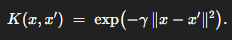
            
        - Polynomial kernel
            
            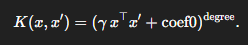
            
        - Sigmoid kernel
            
            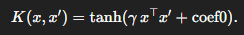
        
    - `degree`, e.g. [1, 2, 3]
        - This represents the degree of the polynomial when the 'Polynomial' kernel trick is used.
        - For example, degree=1: equivalent to a linear kernel; degree>1: more complex polynomial boundary.
    
    - `gamma`, e.g. ["auto", "scale", 0.1, 0.01, 0.001]
        - This is the kernel coefficient for RBF, Polynomial, and Sigmoid kernel trick.
        - This hyper-parameter's role is dependent on the kernel trick used.
            - RBF: It controls how far a training data point's influence when shaping the decision boundary. Small gamma would cause each training data point to influence a larger region, creating a smoother decision boundary.
            - Polynomial: A larger γ makes higher-order interactions more pronounced, producing more complex curved surfaces.
            - Sigmoid: gamma controls the slope of the sigmoid function applied to the dot product of inputs, affecting how sharply the model separates classes.
        - "auto": where $Var(X)$ is the mean variance of each individual feature in feature set X,
        $$gamma = \frac{1}{n_features   *   Var(X)}$$
        - "scale": $$gamma = \frac{1}{n_features}$$
    
    - `coef0`, e.g. [-0.4, -0.2, 0, 0.2, 0.4]
        - This only applies to Polynomial and Sigmoid kernels, where it acts as an addicitve constant in the kernel functions.
        - In Polynomial kernel, a larger coef0 makes even small inner products contribute significantly once exponentiated, i.e. it emphasizes the higher-degree terms. While smaller (or negative) coef0 would down-weights those high-order terms, making the decision boundary more linear.
        - In Sigmoid kernel, it controls the threshold at which the kernel output switches sign. A larger coef0 would shift the tanh input to the right, making it easier for the kernel value K to land in the +1 region of the tanh function (Recall that the tanh function is S-shaped, ranging between -1 and +1). As a result, more pairs (x, x') are considered similar by the model.

In [1167]:
def run_svm_tuning(X, y):
    '''
    This function performs hyper-parameter tuning on SVM model, and return the best model.
    - The SVM model is calibrated using Platt scaling (Sigmoid)
    - Using Random Search and K-Fold cross-validation
    - Binary cross-entropy function as the monitored metric during tuning
    
    Input
    -----
    X: Feature set
    y: Target variable
    
    Output
    ------
    svm_model_calibrated_best: The trained, optimized model
    '''    

    # Define the base model
    svm_model = SVC(
        class_weight='balanced', # Handle imbalanced classes
        random_state=123 # For reproducibility
    )
    # Wrap the model with calibation model
    svm_model_calibrated = CalibratedClassifierCV(
        base_estimator=svm_model,
        method='sigmoid',  # calibration model -> Platt scaling (also known as Sigmoid)
        cv=5,              # K-Fold cross validation
        ensemble=True      # default: averages calibrated outputs from folds
    )
    
    # define hyper-parameter search space for the underlying, base model
        # the underlying base model is prefixed with `base_estimator__`
    svm_param_grid = {
        'base_estimator__C': [0.1, 1, 10], #[0.1, 1, 10, 100],
        'base_estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'base_estimator__degree': [1, 2, 3],
        'base_estimator__gamma': ["auto", "scale", 0.1, 0.01, 0.001],
        'base_estimator__coef0': [-0.4, -0.2, 0, 0.2, 0.4]
    }

    # Use K-Fold cross-validation during tuning
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    
    # Perform hyper-parameter tuning using RandomSearch
    svm_tuning = RandomizedSearchCV(
        svm_model_calibrated,
        svm_param_grid,
        n_iter=200,
        scoring='neg_log_loss', # binary cross-entropy function
        cv=kfold,
        verbose=2,
        random_state=123)

    svm_tuning.fit(X, y)
    print("Best parameters found:", svm_tuning.best_params_)
    print("Best cross-validation score:", svm_tuning.best_score_)
    
    # The best calibrated model
    svm_model_calibrated_best = svm_tuning.best_estimator_
    
    return svm_model_calibrated_best

In [621]:
def train_svm(model, X, y):
    '''
    This function is used to train the SVM model and compute the performance of the ML model.
    - It uses cross-validation to train the specified model and compute the performance metric
    
    Input
    -----
    model: The ML model object
    X: Feature set
    y: Target variable
    '''
    # Define the model
    params_dict = model.base_estimator.get_params()
    
    svm_model = SVC(
        class_weight='balanced',
        C=params_dict['C'],
        kernel=params_dict['kernel'],
        degree=params_dict['degree'],
        gamma=params_dict['gamma'],
        coef0=params_dict['coef0'],
        random_state=123
)
    
    svm_model_calibrated = CalibratedClassifierCV(
        base_estimator=svm_model,
        method='sigmoid',  # calibration model -> Platt scaling (also known as Sigmoid)
        cv=5,              # K-Fold cross validation
        ensemble=True      # default: averages calibrated outputs from folds
    )
    
    # Define per-class F1 scorers
    f1_class_0 = make_scorer(f1_score, average='binary', pos_label=0)
    f1_class_1 = make_scorer(f1_score, average='binary', pos_label=1)   
    
    # Use K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    results = cross_validate(
        estimator=svm_model_calibrated,
        X=X,
        y=y,
        cv=kfold,
        scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro', 'f1_class_0': f1_class_0, 'f1_class_1': f1_class_1},
        return_train_score=True  # Optional: include training scores
    )

    print('Average Accuracy (on Testing Dataset):', results['test_accuracy'].mean())
    print('Average Macro F1-Score (on Testing Dataset):', results['test_f1_macro'].mean())
    print("Test F1 class 0:", results['test_f1_class_0'].mean())
    print("Test F1 class 1:", results['test_f1_class_1'].mean())
    
    # plot calibration diagram
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)
    svm_model_calibrated_trained = svm_model_calibrated.fit(X_train, y_train)
    probs = svm_model_calibrated_trained.predict_proba(X_eval)[:, 1]
    fop, mpv = calibration_curve(y_eval, probs, n_bins=15, normalize=True)

    plt.plot([0,1],[0,1], '--', label='Perfect')
    plt.plot(mpv, fop, marker='.', label='Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()
    
    # plot calibration diagram -> without calibration
    svm_model_trained = svm_model.fit(X_train, y_train)
    probs = svm_model_trained.decision_function(X_eval) # for SVM to output probability, we call `decision_function()` instead of the usual `predict_proba()`
    print(probs)
    fop, mpv = calibration_curve(y_eval, probs, n_bins=15, normalize=True)

    plt.plot([0,1],[0,1], '--', label='Perfect')
    plt.plot(mpv, fop, marker='.', label='Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()

#### Basic Features (SVM)

In [1079]:
# tune and train the model
svm_model_basic = run_svm_tuning(df_basic, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.5s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.3s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.3s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.5s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.4s
[CV] END base_estimator__C=1, base_estimator__coef0=0.2, base_estimator__degree=3, base_estimator__gamma=scale, base_estimator__ker

Average Accuracy (on Testing Dataset): 0.7594603432245457
Average Macro F1-Score (on Testing Dataset): 0.7589531506201195
Test F1 class 0: 0.749806389404708
Test F1 class 1: 0.7680999118355308


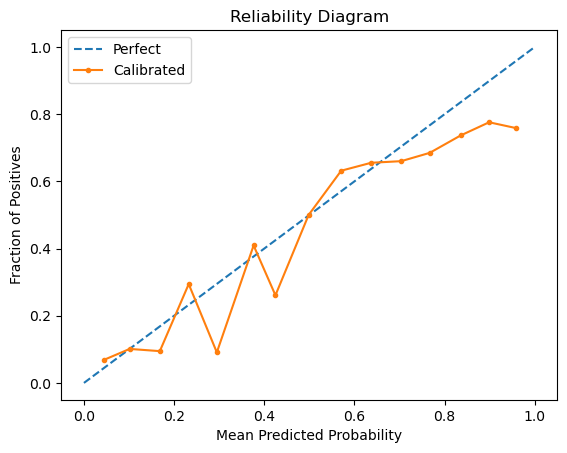

[ 0.50355067  0.29599427  1.11366289 ... -0.72290569  0.63274466
 -0.62739035]


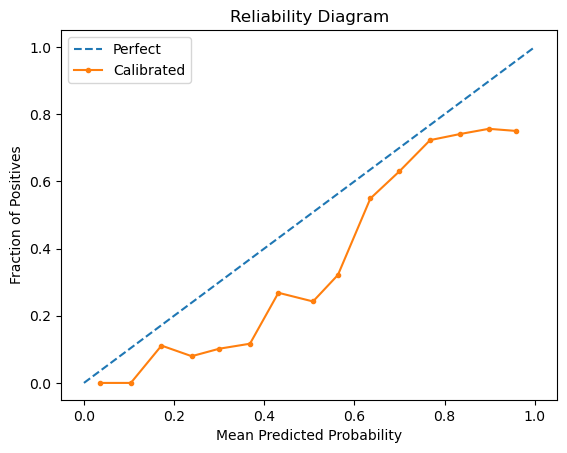

In [1080]:
# compute the performance of the best model 
train_svm(svm_model_basic, df_basic, y)

#### Basic + Financial Features (SVM)

In [1081]:
# tune and train the model
svm_model_basic_financial = run_svm_tuning(df_basic_financial, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.8s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.5s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.7s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.4s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.5s
[CV] END base_estimator__C=1, base_estimator__coef0=0.2, base_estimator__degree=3, base_estimator__gamma=scale, base_estimator__ker

Average Accuracy (on Testing Dataset): 0.7614282112296515
Average Macro F1-Score (on Testing Dataset): 0.7610576775387937
Test F1 class 0: 0.754350249736233
Test F1 class 1: 0.7677651053413546


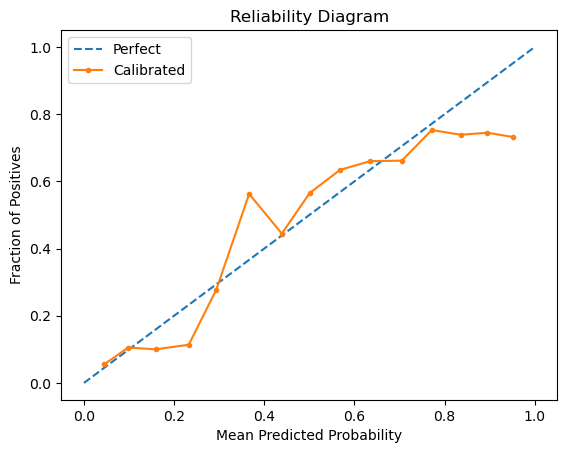

[ 0.59482458  0.44190653  1.14085686 ... -0.74883351  0.00757102
 -0.63818371]


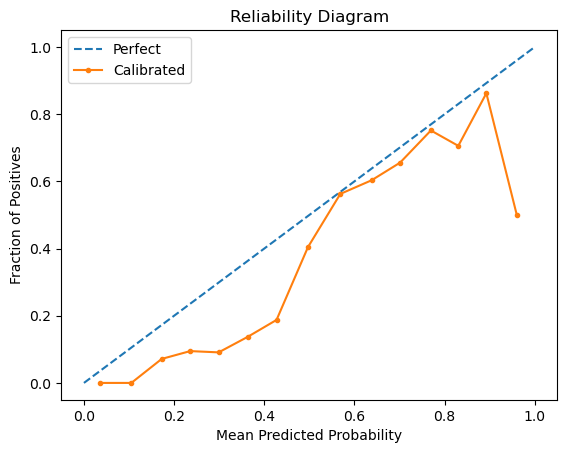

In [1082]:
# compute the performance of the best model 
train_svm(svm_model_basic_financial, df_basic_financial, y)

#### Basic + Macro-Economy Features (SVM)

In [1083]:
# Hyper-parameter tuning
svm_model_basic_macroecon = run_svm_tuning(df_basic_macroecon, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.5s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.4s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.5s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.3s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.1s
[CV] END base_estimator__C=1, base_estimator__coef0=0.2, base_estimator__degree=3, base_estimator__gamma=scale, base_estimator__ker

Average Accuracy (on Testing Dataset): 0.7588993334068739
Average Macro F1-Score (on Testing Dataset): 0.7584958927221053
Test F1 class 0: 0.7527642199992044
Test F1 class 1: 0.7642275654450064


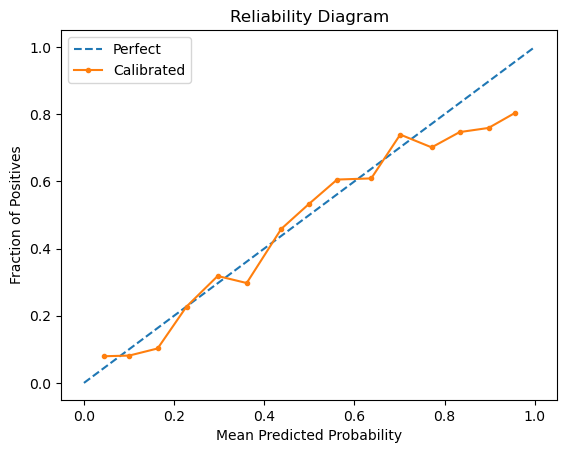

[ 0.35480132  0.40273558  1.09059156 ... -0.65394015  0.78356735
 -0.53563596]


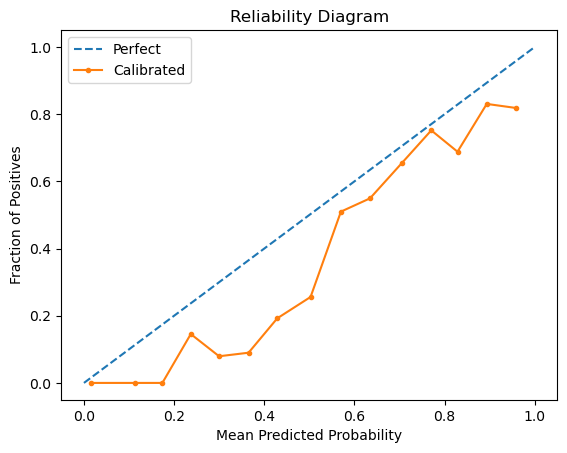

In [1084]:
# compute the performance of the best model 
train_svm(svm_model_basic_macroecon, df_basic_macroecon, y)

#### Basic + Financial + Macro-Economy Features (SVM)

In [1088]:
# Hyper-parameter tuning
svm_model_basic_financial_macroecon = run_svm_tuning(df_basic_financial_macroecon, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.5s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.1s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.1s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.1s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.0s
[CV] END base_estimator__C=1, base_estimator__coef0=0.2, base_estimator__degree=3, base_estimator__gamma=scale, base_estimator__ker

Average Accuracy (on Testing Dataset): 0.760585514600438
Average Macro F1-Score (on Testing Dataset): 0.7603376950674052
Test F1 class 0: 0.7563717607907672
Test F1 class 1: 0.7643036293440434


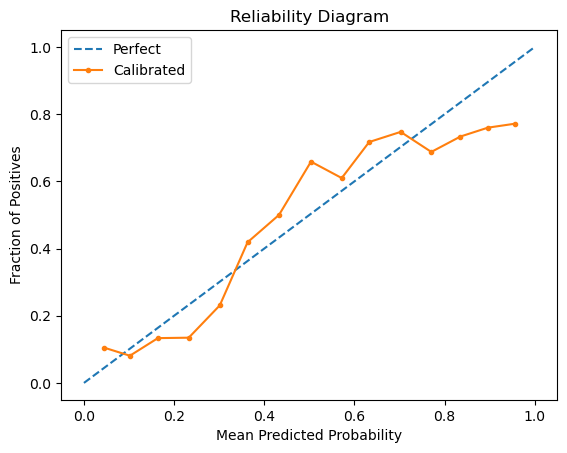

[ 0.3691024   0.37040781  1.2822753  ... -0.6712331  -0.02828622
 -0.49840965]


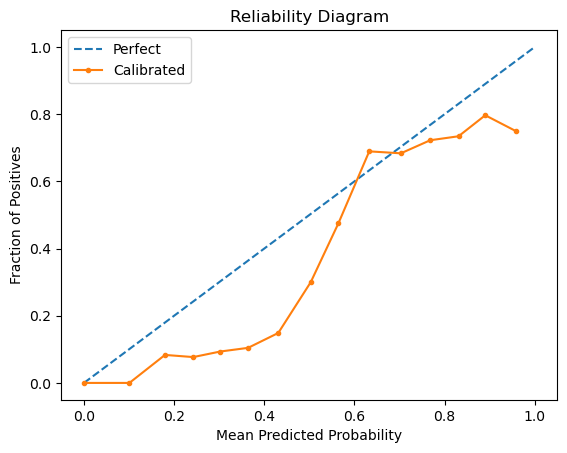

In [1089]:
# compute the performance of the best model 
train_svm(svm_model_basic_financial_macroecon, df_basic_financial_macroecon, y)

#### Financial Features (SVM)

In [1172]:
# Hyper-parameter tuning
svm_tuning_financial = run_svm_tuning(df_financial, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.7s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   2.0s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   2.1s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.7s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   1.8s
[CV] END base_estimator__C=1, base_estimator__coef0=0.2, base_estimator__degree=3, base_estimator__gamma=scale, base_estimator__ker

Average Accuracy (on Testing Dataset): 0.5562747214649291
Average Macro F1-Score (on Testing Dataset): 0.5547652647395348
Test F1 class 0: 0.5792542497548219
Test F1 class 1: 0.5302762797242478


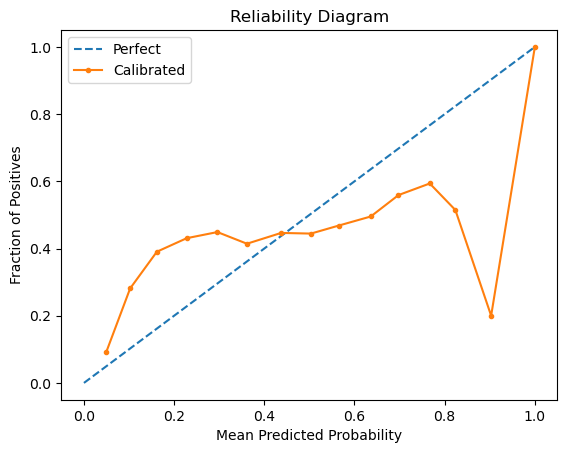

[ 1.0721618  -0.18079729  0.5452411  ...  1.0327416   0.7537336
  0.02821887]


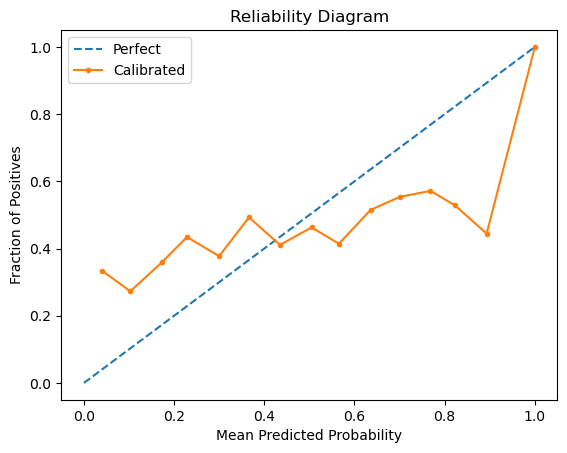

In [1173]:
# Train logit with the optimized hyper-parameters
train_svm(svm_tuning_financial, df_financial, y)

#### Macroeconomic Features (SVM)

In [1179]:
# Hyper-parameter tuning
svm_tuning_macroecon = run_svm_tuning(df_macroecon, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   2.5s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   2.2s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   2.4s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   2.2s
[CV] END base_estimator__C=10, base_estimator__coef0=-0.4, base_estimator__degree=1, base_estimator__gamma=0.01, base_estimator__kernel=poly; total time=   2.4s
[CV] END base_estimator__C=1, base_estimator__coef0=0.2, base_estimator__degree=3, base_estimator__gamma=scale, base_estimator__ker

Average Accuracy (on Testing Dataset): 0.522027908662559
Average Macro F1-Score (on Testing Dataset): 0.36582930049988904
Test F1 class 0: 0.6796271166731793
Test F1 class 1: 0.05203148432659875


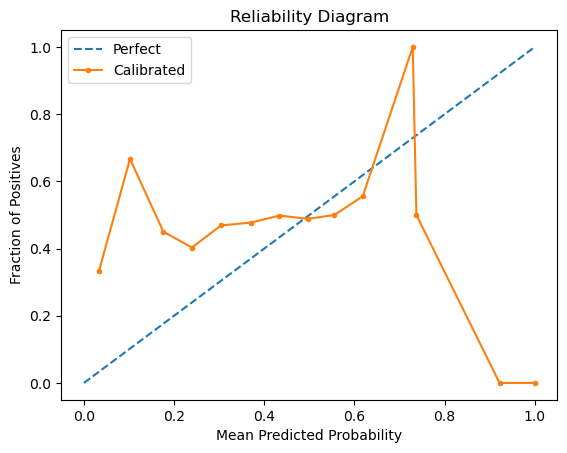

[-2.18975696  0.57191471 -0.41190296 ... -0.81760582 -0.81090326
  0.78204331]


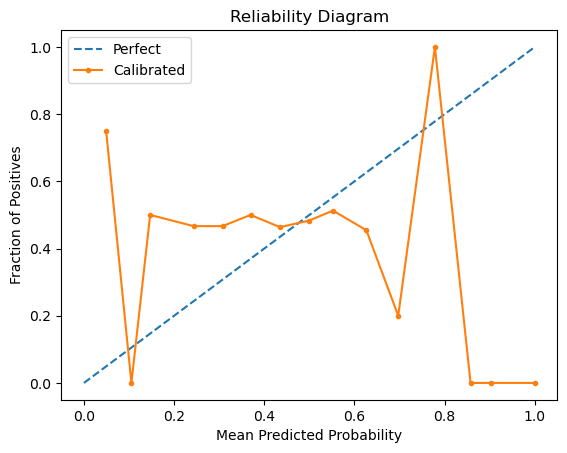

In [1180]:
# Train logit with the optimized hyper-parameters
train_svm(svm_tuning_macroecon, df_macroecon, y)

## Random Forest

- Random forest tend to be overconfident when outputing probability predictions (i.e. predicted probabilities are mostly near 0 or 1), particularly in regions with limited data.

    Therefore, this would cause some issues when we perform tuning with log loss function as the scoring metric. This is because log loss evaluates the quality of the predicted probabilities, rather than the hard classification. And so, the Platt Scaling model is used to calibrate the probability output from the random forest model.
    
- Note that the calibration model is applied during both hyper-parameter tuning and on the most optimal model.

In [1055]:
def run_rf_tuning(X, y):
    '''
    This function performs hyper-parameter tuning on random forest model, and return the best model.
    - The random forest model is calibrated using Platt scaling (Sigmoid)
    - Using Random Search and K-Fold cross-validation
    - Binary cross-entropy function as the monitored metric during tuning
    
    Input
    -----
    X: Feature set
    y: Target variable
    
    Output
    ------
    rf_model_calibrated_best: The trained, optimized model
    '''    

    # Define the base model
    rf_model = RandomForestClassifier(
        class_weight='balanced', # Handle imbalanced classes
        random_state=123 # For reproducibility
    )
    # Wrap the model with calibation model
    rf_model_calibrated = CalibratedClassifierCV(
        base_estimator=rf_model,
        method='sigmoid',  # calibration model -> Platt scaling (also known as Sigmoid)
        cv=5,              # K-Fold cross validation
        ensemble=True      # default: averages calibrated outputs from folds
    )
    
    # define hyper-parameter search space for the underlying, base model
        # the underlying base model is prefixed with `base_estimator__`
    rf_param_grid = {
        'base_estimator__n_estimators': [10, 20, 40, 80, 160, 320], # Number of trees
        'base_estimator__max_depth': [None, 5, 10, 15, 20], # Max depth of each tree
        'base_estimator__min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
        'base_estimator__min_samples_leaf': [1, 2, 4], # Minimum number of samples at each leaf node
        'base_estimator__max_features': ['sqrt', 'log2'] # Number of features the RF considers at each node
    }

    # Use K-Fold cross-validation during tuning
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    
    # Perform hyper-parameter tuning using RandomSearch
    rf_tuning = RandomizedSearchCV(
        rf_model_calibrated,
        rf_param_grid,
        n_iter=200,
        scoring='neg_log_loss', # binary cross-entropy function
        cv=kfold,
        verbose=2,
        random_state=123)

    rf_tuning.fit(X, y)
    print("Best parameters found:", rf_tuning.best_params_)
    print("Best cross-validation score:", rf_tuning.best_score_)
    
    # The best calibrated model
        # Note that rf_model_calibrated_best is already fitted with the best set of hyper-parameters, including
        # ... the calibration model. The rf_model_calibrated_best is re-fitted by RandomizedSearchCV automatically
        # ... using the entire dataset X, y, rather than any of the split during cross-validation.
    rf_model_calibrated_best = rf_tuning.best_estimator_
    
    return rf_model_calibrated_best

In [1057]:
def train_rf(model, X, y):
    '''
    This function is used to train the random forest model and compute the performance of the ML model.
    - It uses cross-validation to train the specified model and compute the performance metric
    
    Input
    -----
    model: The calibrated ML model object
    X: Feature set
    y: Target variable
    '''
    # Define the RF model
    params_dict = model.base_estimator.get_params()
    
    rf_model = RandomForestClassifier(
        class_weight='balanced',
        max_features=params_dict['max_features'],
        min_samples_split=params_dict['min_samples_split'],
        min_samples_leaf=params_dict['min_samples_leaf'],
        n_estimators=params_dict['n_estimators'],
        max_depth=params_dict['max_depth'],
        random_state=111
)
    
    rf_model_calibrated = CalibratedClassifierCV(
        base_estimator=rf_model,
        method='sigmoid',  # calibration model -> Platt scaling (also known as Sigmoid)
        cv=5,              # K-Fold cross validation
        ensemble=True      # default: averages calibrated outputs from folds
    )
    
    # Define per-class F1 scorers
    f1_class_0 = make_scorer(f1_score, average='binary', pos_label=0)
    f1_class_1 = make_scorer(f1_score, average='binary', pos_label=1)   
    
    # Use K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    results = cross_validate(
        estimator=rf_model_calibrated,
        X=X,
        y=y,
        cv=kfold,
        scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro', 'f1_class_0': f1_class_0, 'f1_class_1': f1_class_1},
        return_train_score=True  # Optional: include training scores
    )

    print('Average Accuracy (on Testing Dataset):', results['test_accuracy'].mean())
    print('Average Macro F1-Score (on Testing Dataset):', results['test_f1_macro'].mean())
    print("Test F1 class 0:", results['test_f1_class_0'].mean())
    print("Test F1 class 1:", results['test_f1_class_1'].mean())
    
    # plot calibration diagram -> with calibration
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)
    rf_model_calibrated_trained = rf_model_calibrated.fit(X_train, y_train)
    probs = rf_model_calibrated_trained.predict_proba(X_eval)[:, 1]
    fop, mpv = calibration_curve(y_eval, probs, n_bins=15, normalize=True)

    plt.plot([0,1],[0,1], '--', label='Perfect')
    plt.plot(mpv, fop, marker='.', label='Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()
    
    # plot calibration diagram -> without calibration
    rf_model_trained = rf_model.fit(X_train, y_train)
    probs = rf_model_trained.predict_proba(X_eval)[:, 1]
    fop, mpv = calibration_curve(y_eval, probs, n_bins=15, normalize=True)

    plt.plot([0,1],[0,1], '--', label='Perfect')
    plt.plot(mpv, fop, marker='.', label='Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()

#### Basic Features (Random Forest)

In [1059]:
# tune and train the model
rf_model_basic = run_rf_tuning(df_basic, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.2s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.2s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.2s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.2s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_sp

Average Accuracy (on Testing Dataset): 0.7765802039176135
Average Macro F1-Score (on Testing Dataset): 0.7764380702942602
Test F1 class 0: 0.7794619480628133
Test F1 class 1: 0.7734141925257066


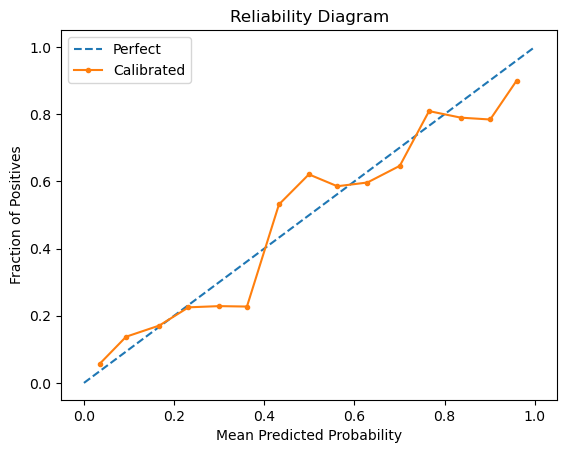

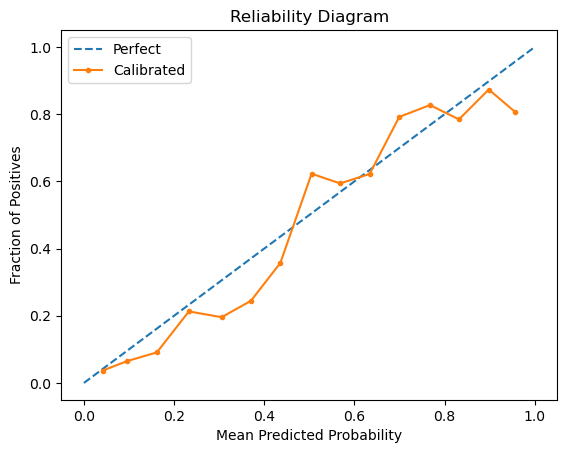

In [1060]:
# compute the performance of the best model 
train_rf(rf_model_basic, df_basic, y)

#### Basic + Financial Features (Random Forest)

In [1061]:
# tune and train the model
rf_model_basic_financial = run_rf_tuning(df_basic_financial, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.4s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.4s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.3s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.3s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_sp

Average Accuracy (on Testing Dataset): 0.782758403328238
Average Macro F1-Score (on Testing Dataset): 0.7825919968220989
Test F1 class 0: 0.782128347768189
Test F1 class 1: 0.7830556458760088


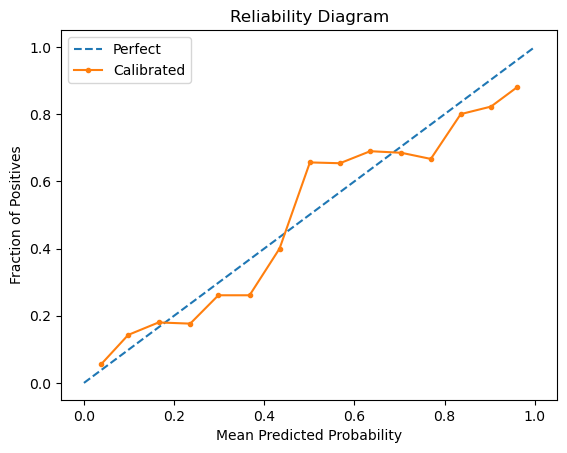

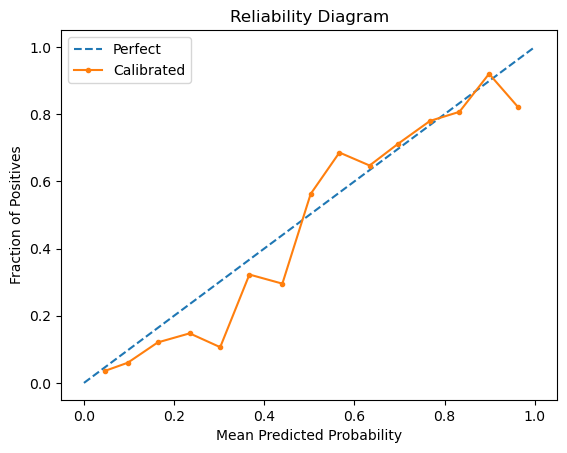

In [1062]:
# compute the performance of the best model 
train_rf(rf_model_basic_financial, df_basic_financial, y)

#### Basic + Macro-Economy Features (Random Forest)

In [1064]:
# Hyper-parameter tuning
rf_model_basic_macroecon = run_rf_tuning(df_basic_macroecon, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.3s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.2s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.2s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.3s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_sp

Average Accuracy (on Testing Dataset): 0.7810718281671053
Average Macro F1-Score (on Testing Dataset): 0.7808924941818579
Test F1 class 0: 0.7810773216334221
Test F1 class 1: 0.7807076667302938


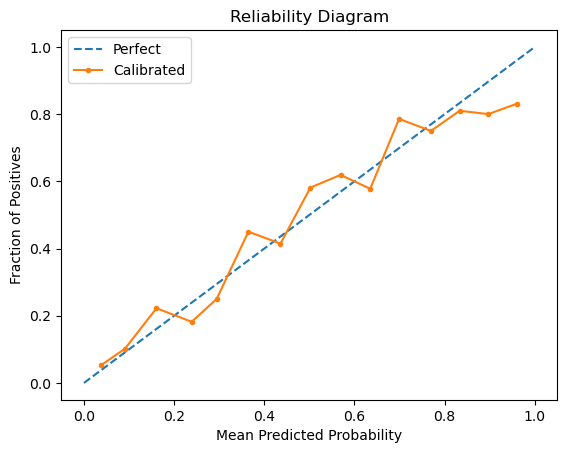

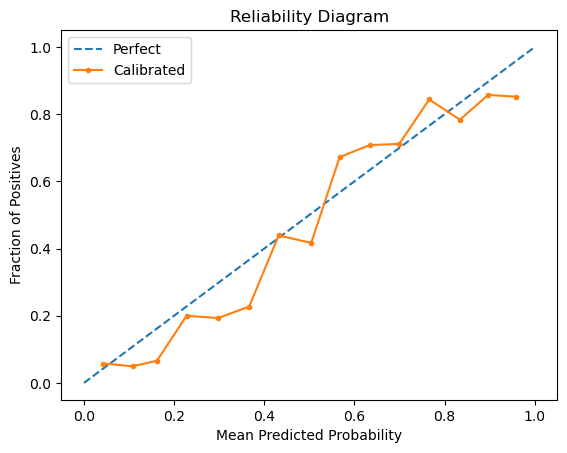

In [1065]:
# compute the performance of the best model 
train_rf(rf_model_basic_macroecon, df_basic_macroecon, y)

#### Basic + Financial + Macro-Economy Features (Random Forest)

In [1067]:
# Hyper-parameter tuning
rf_model_basic_financial_macroecon = run_rf_tuning(df_basic_financial_macroecon, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.5s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.6s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.4s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.4s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_sp

Average Accuracy (on Testing Dataset): 0.7855642403517342
Average Macro F1-Score (on Testing Dataset): 0.7853110952855783
Test F1 class 0: 0.783971109921682
Test F1 class 1: 0.7866510806494746


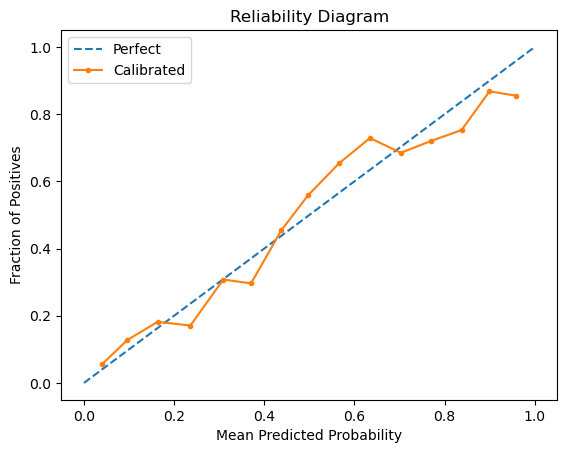

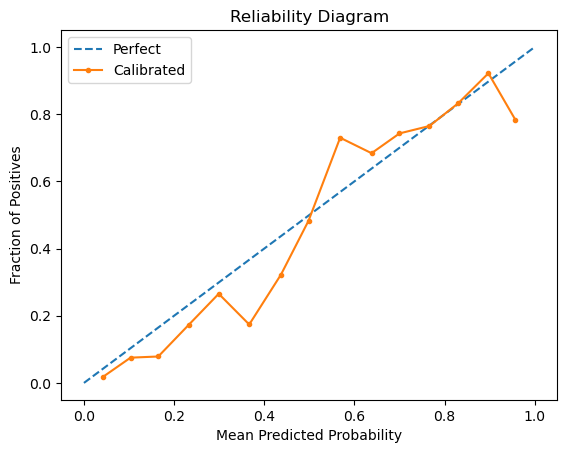

In [1068]:
# compute the performance of the best model 
train_rf(rf_model_basic_financial_macroecon, df_basic_financial_macroecon, y)

#### Financial Features (Random Forest)

In [1183]:
# Hyper-parameter tuning
rf_tuning_financial = run_rf_tuning(df_financial, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.4s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.3s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.3s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.3s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_sp

Average Accuracy (on Testing Dataset): 0.556831791606915
Average Macro F1-Score (on Testing Dataset): 0.5520791147774232
Test F1 class 0: 0.5968544319287767
Test F1 class 1: 0.5073037976260698


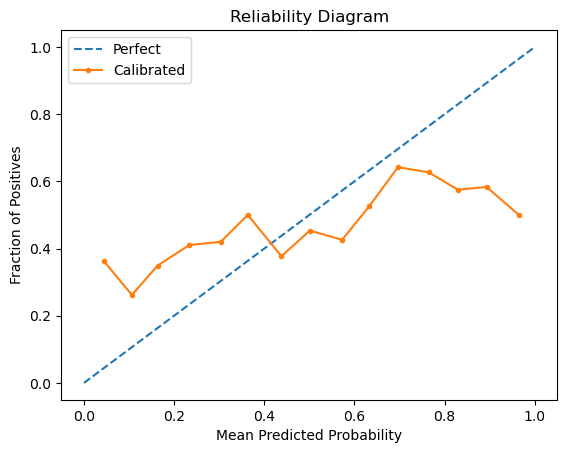

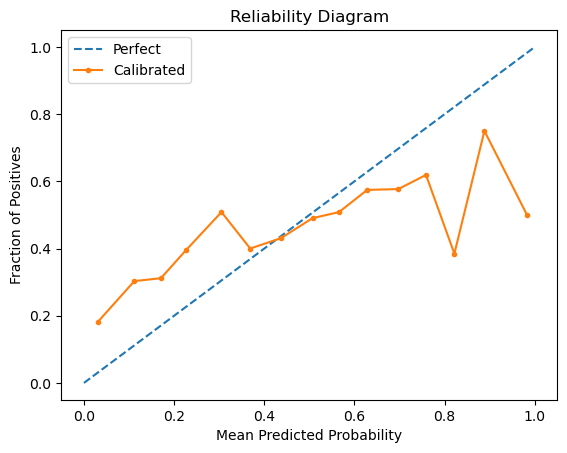

In [1184]:
# Train logit with the optimized hyper-parameters
train_rf(rf_tuning_financial, df_financial, y)

#### Macroeconomic Features (Random Forest)

In [1185]:
# Hyper-parameter tuning
rf_tuning_macroecon = run_rf_tuning(df_macroecon, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.3s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.3s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.4s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_split=5, base_estimator__n_estimators=10; total time=   0.4s
[CV] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_leaf=4, base_estimator__min_samples_sp

Average Accuracy (on Testing Dataset): 0.49088634823581323
Average Macro F1-Score (on Testing Dataset): 0.4157521881462058
Test F1 class 0: 0.6157810903969588
Test F1 class 1: 0.2157232858954526


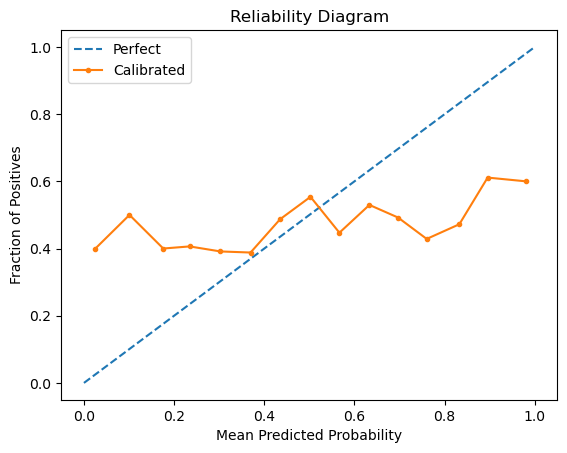

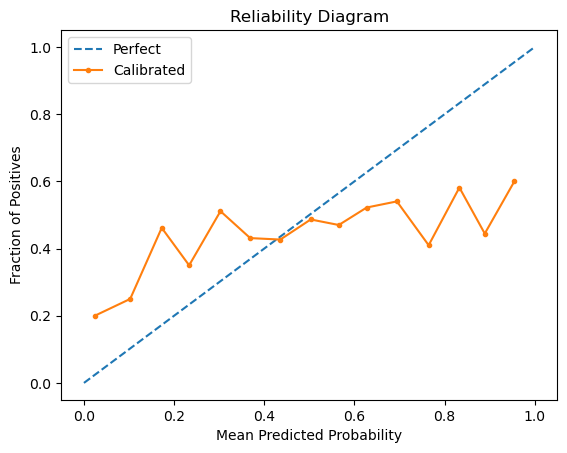

In [1186]:
# Train logit with the optimized hyper-parameters
train_rf(rf_tuning_macroecon, df_macroecon, y)

## XGBoost

Hyperparameters in `XGBClassifier` function,
- `n_estimators`
    - It represents the number of trees contructed, i.e. the number of boosting rounds.
    - Too low → underfitting; too high → overfitting (unless you use early stopping).
- `learning_rate`
    - It represents the learning rate in the gradient descent equation. As shown in the image below,
    
    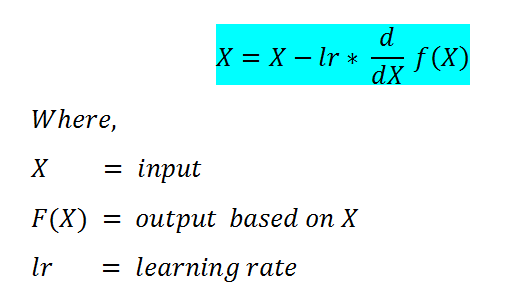
    - Lower values make training slower but often more accurate.
- `max_depth`
    - It controls the maximum depth of a tree.
    - Higher values increase complexity and risk overfitting.
- `min_child_weight`
    - It refers to "cover", i.e. the sum of the Hessian in a node, which is used in the denominator of the Similarity Score computation
    
        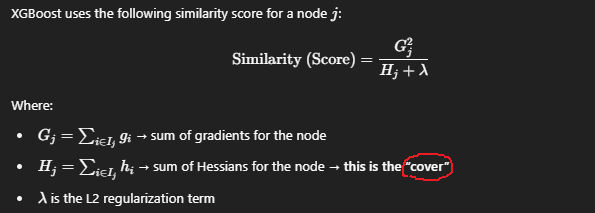
    - And so the 'min_child_weight' hyper-parameter sets a lower bound on this quantity when growing a tree. The idea is that small "cover" indicates that the node has too few or weakly influential samples, and therefore, XGBoost should avoid spliting the node, preventing overfitting

- `gamma`
    - This hyper-parameter is used for pruning. It represents the minimum required gain to make a split at a tree node.
    
        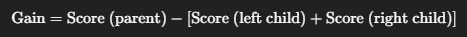
    
        If the gain < gamma, the split is pruned.
    
- `subsample`
    - Fraction of training samples used per tree, useful to prevent overfitting.
- `colsample_bytree`
    - Fraction of features sampled per tree
- `colsample_bylevel`
    - Fraction of features sampled per split
- `reg_lambda`
    - It controls the strenght of the L2 regularization
- `reg_alpha`
    - It controls the strenght of the L1 regularization

In [1151]:
def run_xgb_tuning(X, y):
    '''
    This function performs hyper-parameter tuning on XGBoost model, and return the best model.
    - The XGBoost model is calibrated using Platt scaling (Sigmoid)
    - Using Random Search and K-Fold cross-validation
    - Binary cross-entropy function as the monitored metric during tuning
    
    Input
    -----
    X: Feature set
    y: Target variable
    
    Output
    ------
    xgb_model_calibrated_best: The trained, optimized model
    '''    

    # Define the base model
    xgb_model = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=123
    )
    
    # Wrap the model with calibation model
    xgb_model_calibrated = CalibratedClassifierCV(
        base_estimator=xgb_model,
        method='sigmoid',  # calibration model -> Platt scaling (also known as Sigmoid)
        cv=5,              # K-Fold cross validation
        ensemble=True      # default: averages calibrated outputs from folds
    )
    
    # define hyper-parameter search space for the underlying, base model
        # the underlying base model is prefixed with `base_estimator__`
    xgb_param_grid = {
        'base_estimator__n_estimators': [100, 200, 300],
        'base_estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'base_estimator__max_depth': [3, 5, 7, 10],
        'base_estimator__min_child_weight': [1, 3, 5, 10, 20],
        'base_estimator__gamma': [0, 0.1, 0.3, 1, 5],
        'base_estimator__subsample': [0.6, 0.8, 1.0],
        'base_estimator__colsample_bytree': [0.6, 0.8, 1.0],
        'base_estimator__colsample_bylevel': [0.6, 0.8, 1.0],
        'base_estimator__reg_lambda': [0, 1, 5, 10]
    }

    # Use K-Fold cross-validation during tuning
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    
    # Perform hyper-parameter tuning using RandomSearch
    xgb_tuning = RandomizedSearchCV(
        xgb_model_calibrated,
        xgb_param_grid,
        n_iter=100,
        scoring='neg_log_loss', # binary cross-entropy function
        cv=kfold,
        verbose=2,
        random_state=123)

    xgb_tuning.fit(X, y)
    print("Best parameters found:", xgb_tuning.best_params_)
    print("Best cross-validation score:", xgb_tuning.best_score_)
    
    # The best calibrated model
    xgb_model_calibrated_best = xgb_tuning.best_estimator_
    
    return xgb_model_calibrated_best

In [950]:
def train_xgb(model, X, y):
    '''
    This function is used to train the XGBoost model and compute the performance of the ML model.
    - It uses cross-validation to train the specified model and compute the performance metric
    
    Input
    -----
    model: The ML model object
    X: Feature set
    y: Target variable
    '''
    # Define the model
    params_dict = model.base_estimator.get_params()
    
    xgb_model = XGBClassifier(
        objective ='binary:logistic',
        use_label_encoder = False,
        eval_metric = 'logloss',
        n_estimators = params_dict['n_estimators'],
        learning_rate = params_dict['learning_rate'],
        max_depth = params_dict['max_depth'],
        min_child_weight = params_dict['min_child_weight'],
        gamma = params_dict['gamma'],
        subsample = params_dict['subsample'],
        colsample_bytree = params_dict['colsample_bytree'],
        colsample_bylevel = params_dict['colsample_bylevel'],
        reg_lambda = params_dict['reg_lambda'],
        random_state=123
    )
    
    xgb_model_calibrated = CalibratedClassifierCV(
        base_estimator=xgb_model,
        method='sigmoid',  # calibration model -> Platt scaling (also known as Sigmoid)
        cv=5,              # K-Fold cross validation
        ensemble=True      # default: averages calibrated outputs from folds
    )
    
    # Define per-class F1 scorers
    f1_class_0 = make_scorer(f1_score, average='binary', pos_label=0)
    f1_class_1 = make_scorer(f1_score, average='binary', pos_label=1)   
    
    # Use K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    results = cross_validate(
        estimator=xgb_model_calibrated,
        X=X,
        y=y,
        cv=kfold,
        scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro', 'f1_class_0': f1_class_0, 'f1_class_1': f1_class_1},
        return_train_score=True  # Optional: include training scores
    )

    print('Average Accuracy (on Testing Dataset):', results['test_accuracy'].mean())
    print('Average Macro F1-Score (on Testing Dataset):', results['test_f1_macro'].mean())
    print("Test F1 class 0:", results['test_f1_class_0'].mean())
    print("Test F1 class 1:", results['test_f1_class_1'].mean())
    
    # plot calibration diagram
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)
    xgb_model_calibrated_trained = xgb_model_calibrated.fit(X_train, y_train)
    probs = xgb_model_calibrated_trained.predict_proba(X_eval)[:, 1]
    fop, mpv = calibration_curve(y_eval, probs, n_bins=15, normalize=True)

    plt.plot([0,1],[0,1], '--', label='Perfect')
    plt.plot(mpv, fop, marker='.', label='Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()
    
    # plot calibration diagram -> without calibration
    xgb_model_trained = xgb_model.fit(X_train, y_train)
    probs = xgb_model_trained.predict_proba(X_eval)[:, 1]
    fop, mpv = calibration_curve(y_eval, probs, n_bins=15, normalize=True)

    plt.plot([0,1],[0,1], '--', label='Perfect')
    plt.plot(mpv, fop, marker='.', label='Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()

#### Basic Features (XGBoost)

In [1035]:
# tune and train the model
xgb_model_basic = run_xgb_tuning(df_basic, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   1.3s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   0.9s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, 

Average Accuracy (on Testing Dataset): 0.7886501883164978
Average Macro F1-Score (on Testing Dataset): 0.7885062625676111
Test F1 class 0: 0.789586432191925
Test F1 class 1: 0.7874260929432974


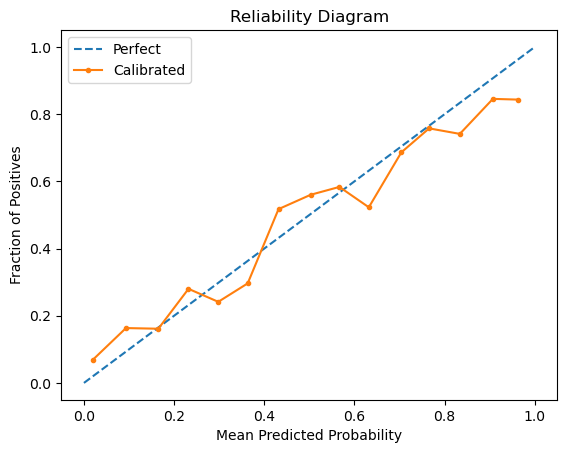

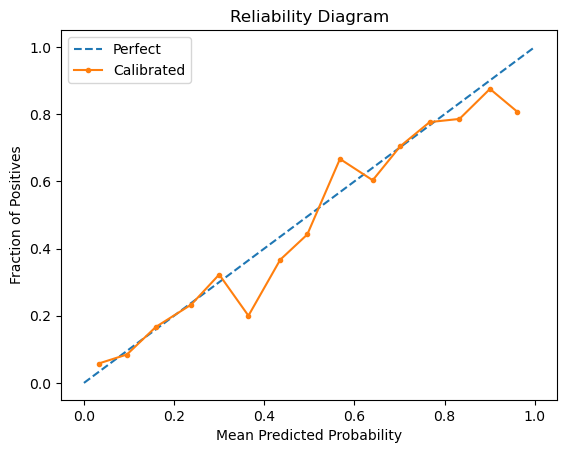

In [1037]:
# compute the performance of the best model 
train_xgb(xgb_model_basic, df_basic, y)

#### Basic + Financial Features (XGBoost)

In [1039]:
# tune and train the model
xgb_model_basic_financial = run_xgb_tuning(df_basic_financial, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   1.4s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   1.4s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, 

Average Accuracy (on Testing Dataset): 0.7897765415950959
Average Macro F1-Score (on Testing Dataset): 0.789649553153834
Test F1 class 0: 0.7890855667191579
Test F1 class 1: 0.79021353958851


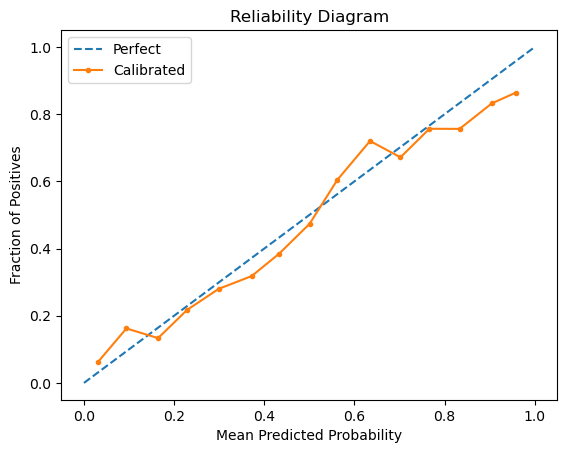

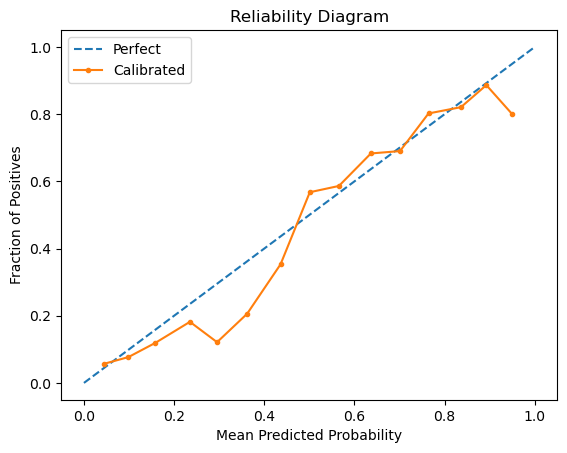

In [1041]:
# compute the performance of the best model 
train_xgb(xgb_model_basic_financial, df_basic_financial, y)

#### Basic + Macro-Economy Features (XGBoost)

In [1043]:
# Hyper-parameter tuning
xgb_model_basic_macroecon = run_xgb_tuning(df_basic_macroecon, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   1.2s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   1.2s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, 

Average Accuracy (on Testing Dataset): 0.7892088343287581
Average Macro F1-Score (on Testing Dataset): 0.7890897547282976
Test F1 class 0: 0.7871090540653547
Test F1 class 1: 0.7910704553912407


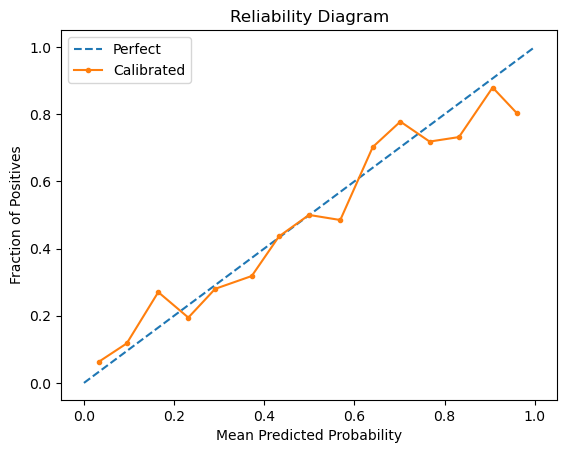

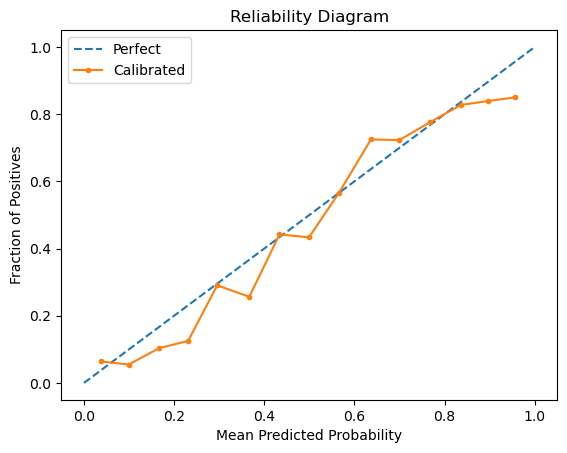

In [1044]:
# compute the performance of the best model 
train_xgb(xgb_model_basic_macroecon, df_basic_macroecon, y)

#### Basic + Financial + Macro-Economy Features (XGBoost)

In [1045]:
# Hyper-parameter tuning
xgb_model_basic_financial_macroecon = run_xgb_tuning(df_basic_financial_macroecon, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   2.6s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   2.7s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, 

Average Accuracy (on Testing Dataset): 0.7937040042863671
Average Macro F1-Score (on Testing Dataset): 0.793491886241025
Test F1 class 0: 0.7951692984478684
Test F1 class 1: 0.7918144740341815


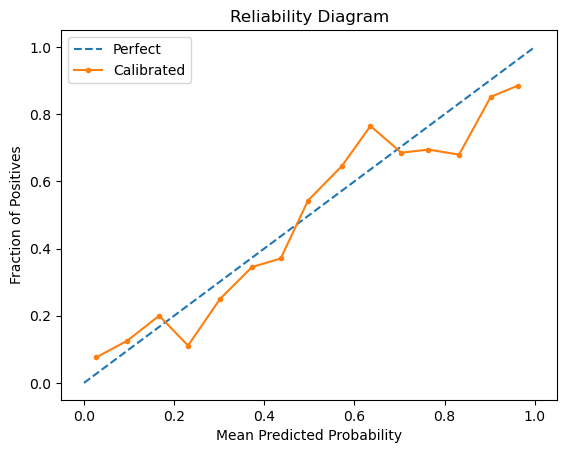

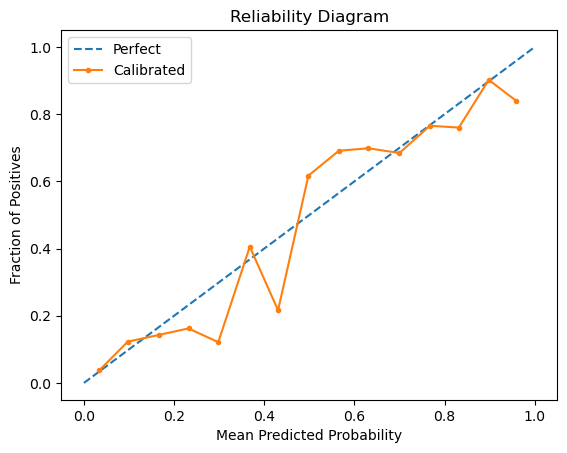

In [1046]:
# compute the performance of the best model 
train_xgb(xgb_model_basic_financial_macroecon, df_basic_financial_macroecon, y)

#### Financial Features (XGBoost)

In [1191]:
# Hyper-parameter tuning
xgb_tuning_financial = run_xgb_tuning(df_financial, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   1.6s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   1.3s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, 

Average Accuracy (on Testing Dataset): 0.5531812881163622
Average Macro F1-Score (on Testing Dataset): 0.5486306060482098
Test F1 class 0: 0.5922429459994869
Test F1 class 1: 0.5050182660969327


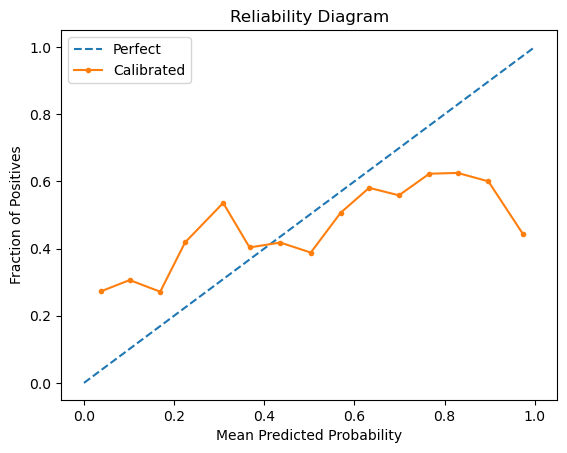

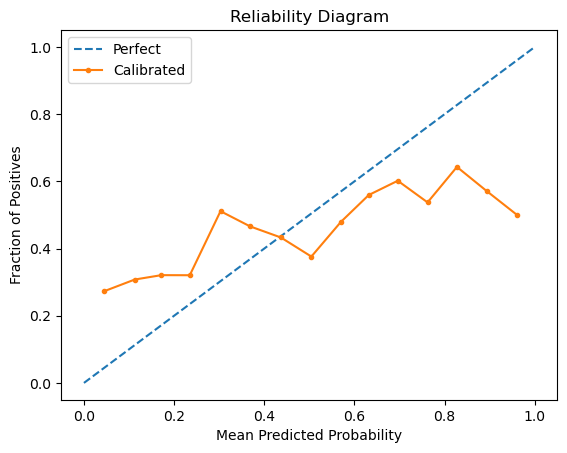

In [1192]:
# Train logit with the optimized hyper-parameters
train_xgb(xgb_tuning_financial, df_financial, y)

#### Macroeconomic Features (XGBoost)

In [1193]:
# Hyper-parameter tuning
xgb_tuning_macroecon = run_xgb_tuning(df_macroecon, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   0.8s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, base_estimator__subsample=0.8; total time=   0.9s
[CV] END base_estimator__colsample_bylevel=1.0, base_estimator__colsample_bytree=1.0, base_estimator__gamma=0.1, base_estimator__learning_rate=0.01, base_estimator__max_depth=5, base_estimator__min_child_weight=1, base_estimator__n_estimators=100, base_estimator__reg_lambda=10, 

Average Accuracy (on Testing Dataset): 0.5029535748617173
Average Macro F1-Score (on Testing Dataset): 0.3916541884499022
Test F1 class 0: 0.6458065204260256
Test F1 class 1: 0.1375018564737788


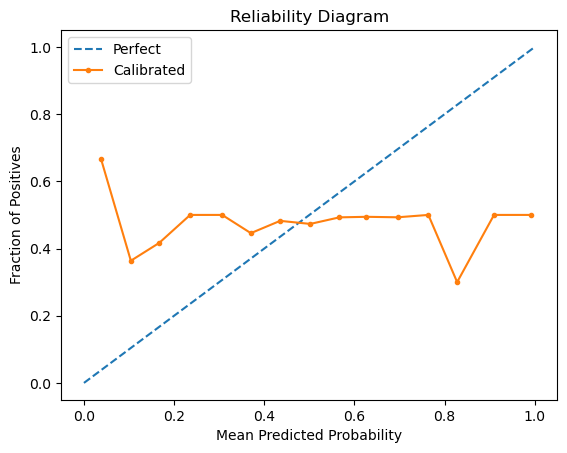

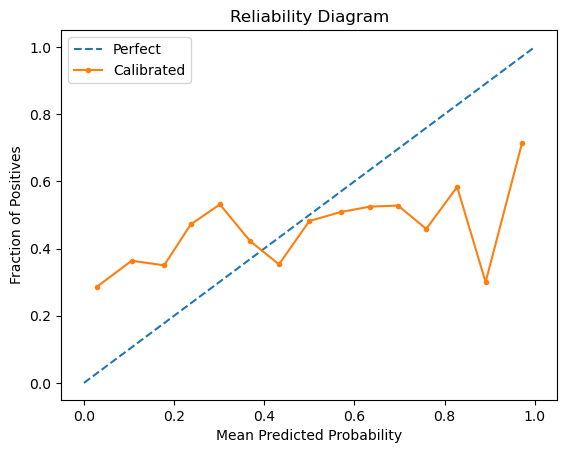

In [1194]:
# Train logit with the optimized hyper-parameters
train_xgb(xgb_tuning_macroecon, df_macroecon, y)

## Forwardfeed Neural Network

In [986]:
# define the model to be tuned
def build_nn_model(hp, num_features):
    # Initiate the NN
    nn = Sequential()

    # input layer
    nn.add(tf.keras.Input(shape=(num_features,)))

    # hidden later
    for i in range(hp.Int("num_hidden_layers", 1, 5, 1)):
        nn.add(tf.keras.layers.Dense(units=hp.Int(f"hidden_neuron_{str(i)}",
                                                   min_value=32, 
                                                   max_value=512,
                                                   step=32),
                                     activation=hp.Choice(f"hidden_act_{str(i)}", ["relu", "tanh", "leaky_relu"]),
                                     kernel_regularizer=regularizers.l2(hp.Choice(f"l2_weight_{str(i)}", [0.0, 1e-5, 1e-4, 1e-3]))
                                    )
              )
        
        rate = hp.Float(f"dropout_rate_{i}", 0.0, 0.4, step=0.1)
        nn.add(tf.keras.layers.Dropout(rate))
        
    # output layer
    nn.add(tf.keras.layers.Dense(units=1,
                                 activation="sigmoid")
          )

    # specify the optimizers and the loss function
    lr = hp.Choice("learning_rate", [1e-4, 3e-4, 1e-3, 3e-3])
    nn.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryCrossentropy()
    )
    
    return nn

In [1009]:
def run_nn_tuning(X, y, file_name):
    '''
    Perform hyper-parameter tuning on NN model using random search
    Input
    -----
    X: The feature set
    y: The target variable
    file_name (str): The foldername to store tuning result
    
    Output
    ------
    best_nn_model: The tuned model
    
    '''
    # define the random search
    num_features = X.shape[1]
    nn_tuner = RandomSearch(
        lambda hp: build_nn_model(hp, num_features=num_features),
        objective="val_loss",
        max_trials=200,
        executions_per_trial=1,
        directory="HyperPara_Tuning",
        project_name=file_name
    )

    # perform the random search
    early_stop = tf.keras.callbacks.EarlyStopping("val_loss", patience=5, restore_best_weights=True)
    nn_tuner.search(
        X,
        y,
        epochs=30,
        batch_size=62,
        validation_split=0.2,
        callbacks=[early_stop],
    )
    
    # the best hyper-parameters
    print(nn_tuner.get_best_hyperparameters()[0].values)
    
    # obtain the best hyper parameters
    best_hyperparams = nn_tuner.get_best_hyperparameters()[0]

    # build the NN model with the best hyper-parameters
    best_nn_model = nn_tuner.hypermodel.build(best_hyperparams)
    
    return best_nn_model

In [954]:
def train_nn(model, X, y):
    '''
    This function is used to train the NN model and compute the performance of the ML model.
    - Early Stopping is implemented when training
    - It uses K-Fold cross-validation to train the specified model and compute the performance metric
    
    Input
    -----
    model: The ML model object
    X: Feature set
    y: Target variable
    '''
    # retain the model using K-Fold cross-validation
    early_stop = tf.keras.callbacks.EarlyStopping("val_loss", patience=5, restore_best_weights=True)
    acc_scores = []
    success_f1_scores = []
    failure_f1_scores = []
    for train_idx, val_idx in kfold.split(X, y):
        # split to training and validation
        nn_X_train, nn_X_val = X.values[train_idx], X.values[val_idx]
        nn_y_train, nn_y_val = y.values[train_idx], y.values[val_idx]

        # train the model
        model.fit(
            nn_X_train,
            nn_y_train,
            batch_size=64,
            epochs=100,
            validation_split=0.2,
            verbose=1,
            callbacks=[early_stop],
            shuffle=True
        )

        # compute prediction
        y_pred_prob = model.predict(nn_X_val)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # compute performance metric
        acc_scores.append(accuracy_score(nn_y_val, y_pred))
        success_f1_scores.append(f1_score(nn_y_val, y_pred, pos_label=1))
        failure_f1_scores.append(f1_score(nn_y_val, y_pred, pos_label=0))

    # compute the average performance metric from K-Fold cross-validation
    avg_acc = sum(acc_scores)/len(acc_scores)
    avg_f1_success = sum(success_f1_scores)/len(success_f1_scores)
    avg_f1_failure = sum(failure_f1_scores)/len(failure_f1_scores)
    macro_avg_f1 = (avg_f1_success + avg_f1_failure) / 2

    print('Accuracy Score:', avg_acc)
    print('Average Macro F1-Score:', macro_avg_f1)
    print('F1-score (class 0):', avg_f1_failure)
    print('F1-score (class 1):', avg_f1_success)

#### Basic Features (NN)

In [1011]:
# tune and train the model
nn_model_basic = run_nn_tuning(df_basic, y, 'basic')

Trial 200 Complete [00h 00m 12s]
val_loss: 0.5869504809379578

Best val_loss So Far: 0.5367326140403748
Total elapsed time: 00h 34m 34s
INFO:tensorflow:Oracle triggered exit
{'num_hidden_layers': 4, 'hidden_neuron_0': 384, 'hidden_act_0': 'relu', 'l2_weight_0': 0.0001, 'dropout_rate_0': 0.30000000000000004, 'learning_rate': 0.003, 'hidden_neuron_1': 32, 'hidden_act_1': 'tanh', 'l2_weight_1': 0.0, 'dropout_rate_1': 0.0, 'hidden_neuron_2': 96, 'hidden_act_2': 'relu', 'l2_weight_2': 1e-05, 'dropout_rate_2': 0.2, 'hidden_neuron_3': 288, 'hidden_act_3': 'leaky_relu', 'l2_weight_3': 1e-05, 'dropout_rate_3': 0.30000000000000004, 'hidden_neuron_4': 448, 'hidden_act_4': 'tanh', 'l2_weight_4': 0.001, 'dropout_rate_4': 0.0}


In [1012]:
# compute the performance of the best model 
train_nn(nn_model_basic, df_basic, y)

Epoch 1/100
36/36 [==============================] - 2s 16ms/step - loss: 0.5849 - val_loss: 0.5961
Epoch 2/100
36/36 [==============================] - 0s 9ms/step - loss: 0.5268 - val_loss: 0.5631
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 0.5117 - val_loss: 0.5806
Epoch 4/100
36/36 [==============================] - 0s 10ms/step - loss: 0.4852 - val_loss: 0.5684
Epoch 5/100
36/36 [==============================] - 0s 9ms/step - loss: 0.4933 - val_loss: 0.5765
Epoch 6/100
36/36 [==============================] - 0s 9ms/step - loss: 0.4745 - val_loss: 0.5721
Epoch 7/100
23/23 [==============================] - 0s 2ms/step
Epoch 1/100
36/36 [==============================] - 0s 11ms/step - loss: 0.4954 - val_loss: 0.5658
Epoch 2/100
36/36 [==============================] - 0s 9ms/step - loss: 0.4805 - val_loss: 0.5861
Epoch 3/100
36/36 [==============================] - 0s 9ms/step - loss: 0.4663 - val_loss: 0.5892
Epoch 4/100
36/36 [=====================

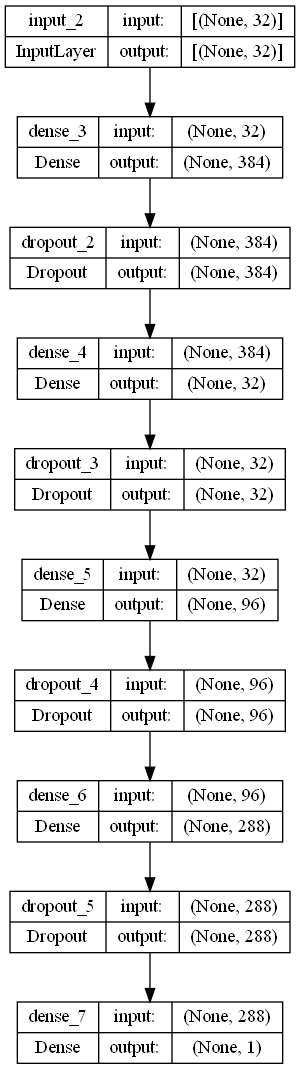

In [1013]:
# vizualize the layers of the NN
plot_model(nn_model_basic, to_file='NN_model.png', show_shapes=True, show_layer_names=True)

#### Basic + Financial Features (NN)

In [1014]:
# tune and train the model
nn_model_basic_financial = run_nn_tuning(df_basic_financial, y, 'basic_financial')

Trial 200 Complete [00h 00m 07s]
val_loss: 0.5661082863807678

Best val_loss So Far: 0.540827214717865
Total elapsed time: 00h 38m 04s
INFO:tensorflow:Oracle triggered exit
{'num_hidden_layers': 4, 'hidden_neuron_0': 128, 'hidden_act_0': 'leaky_relu', 'l2_weight_0': 0.0, 'dropout_rate_0': 0.4, 'learning_rate': 0.003, 'hidden_neuron_1': 128, 'hidden_act_1': 'leaky_relu', 'l2_weight_1': 0.0, 'dropout_rate_1': 0.1, 'hidden_neuron_2': 192, 'hidden_act_2': 'relu', 'l2_weight_2': 1e-05, 'dropout_rate_2': 0.4, 'hidden_neuron_3': 480, 'hidden_act_3': 'relu', 'l2_weight_3': 0.0, 'dropout_rate_3': 0.1, 'hidden_neuron_4': 480, 'hidden_act_4': 'relu', 'l2_weight_4': 0.001, 'dropout_rate_4': 0.1}


In [1015]:
# compute the performance of the best model 
train_nn(nn_model_basic_financial, df_basic_financial, y)

Epoch 1/100
36/36 [==============================] - 2s 17ms/step - loss: 0.6476 - val_loss: 0.5852
Epoch 2/100
36/36 [==============================] - 0s 13ms/step - loss: 0.5588 - val_loss: 0.5659
Epoch 3/100
36/36 [==============================] - 0s 13ms/step - loss: 0.5346 - val_loss: 0.6254
Epoch 4/100
36/36 [==============================] - 0s 12ms/step - loss: 0.5239 - val_loss: 0.5611
Epoch 5/100
36/36 [==============================] - 0s 12ms/step - loss: 0.5167 - val_loss: 0.5760
Epoch 6/100
36/36 [==============================] - 0s 13ms/step - loss: 0.5017 - val_loss: 0.5691
Epoch 7/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4905 - val_loss: 0.5690
Epoch 8/100
36/36 [==============================] - 0s 13ms/step - loss: 0.4898 - val_loss: 0.5675
Epoch 9/100
23/23 [==============================] - 0s 3ms/step
Epoch 1/100
36/36 [==============================] - 1s 14ms/step - loss: 0.5045 - val_loss: 0.5612
Epoch 2/100
36/36 [================

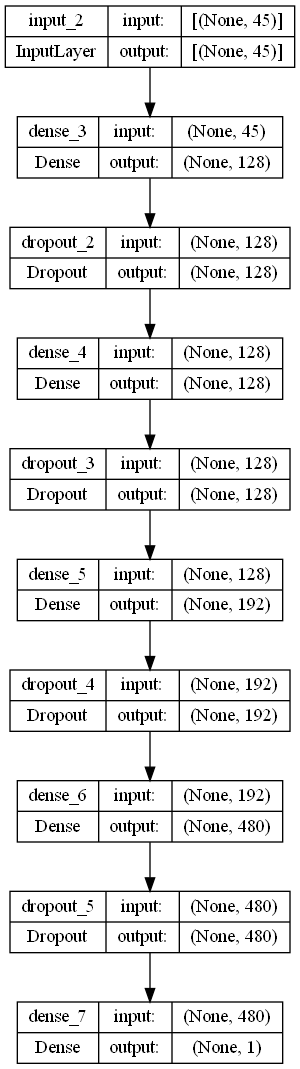

In [1016]:
# vizualize the layers of the NN
plot_model(nn_model_basic_financial, to_file='NN_model.png', show_shapes=True, show_layer_names=True)

#### Basic + Macro-Economy Features (NN)

In [1017]:
# Hyper-parameter tuning
nn_model_basic_macroecon = run_nn_tuning(df_basic_macroecon, y, 'basic_macroecon')

Trial 200 Complete [00h 00m 10s]
val_loss: 0.6237542033195496

Best val_loss So Far: 0.5488477945327759
Total elapsed time: 00h 35m 43s
INFO:tensorflow:Oracle triggered exit
{'num_hidden_layers': 1, 'hidden_neuron_0': 160, 'hidden_act_0': 'tanh', 'l2_weight_0': 0.0, 'dropout_rate_0': 0.2, 'learning_rate': 0.003, 'hidden_neuron_1': 384, 'hidden_act_1': 'tanh', 'l2_weight_1': 0.0001, 'dropout_rate_1': 0.2, 'hidden_neuron_2': 32, 'hidden_act_2': 'tanh', 'l2_weight_2': 0.001, 'dropout_rate_2': 0.0, 'hidden_neuron_3': 352, 'hidden_act_3': 'tanh', 'l2_weight_3': 1e-05, 'dropout_rate_3': 0.30000000000000004, 'hidden_neuron_4': 352, 'hidden_act_4': 'relu', 'l2_weight_4': 0.001, 'dropout_rate_4': 0.30000000000000004}


In [1018]:
# compute the performance of the best model 
train_nn(nn_model_basic_macroecon, df_basic_macroecon, y)

Epoch 1/100
36/36 [==============================] - 1s 10ms/step - loss: 0.5827 - val_loss: 0.6110
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.5446 - val_loss: 0.5888
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.5401 - val_loss: 0.5998
Epoch 4/100
36/36 [==============================] - 0s 4ms/step - loss: 0.5284 - val_loss: 0.6042
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5262 - val_loss: 0.5852
Epoch 6/100
36/36 [==============================] - 0s 4ms/step - loss: 0.5308 - val_loss: 0.5906
Epoch 7/100
36/36 [==============================] - 0s 4ms/step - loss: 0.5244 - val_loss: 0.5984
Epoch 8/100
36/36 [==============================] - 0s 4ms/step - loss: 0.5188 - val_loss: 0.5923
Epoch 9/100
36/36 [==============================] - 0s 6ms/step - loss: 0.5117 - val_loss: 0.5838
Epoch 10/100
36/36 [==============================] - 0s 5ms/step - loss: 0.5181 - val_loss: 0.5911
Epoch 11

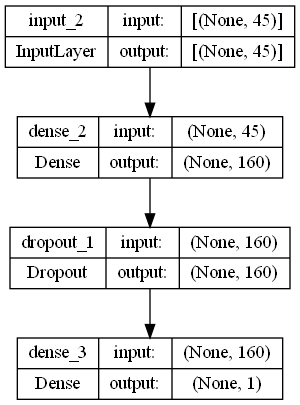

In [1019]:
# vizualize the layers of the NN
plot_model(nn_model_basic_macroecon, to_file='NN_model.png', show_shapes=True, show_layer_names=True)

#### Basic + Financial + Macro-Economy Features (NN)

In [1020]:
# Hyper-parameter tuning
nn_model_basic_financial_macroecon = run_nn_tuning(df_basic_financial_macroecon, y, 'basic_financial_macroecon')

Trial 200 Complete [00h 00m 10s]
val_loss: 0.6168030500411987

Best val_loss So Far: 0.5522227883338928
Total elapsed time: 00h 36m 47s
INFO:tensorflow:Oracle triggered exit
{'num_hidden_layers': 3, 'hidden_neuron_0': 256, 'hidden_act_0': 'leaky_relu', 'l2_weight_0': 0.0, 'dropout_rate_0': 0.30000000000000004, 'learning_rate': 0.003, 'hidden_neuron_1': 448, 'hidden_act_1': 'tanh', 'l2_weight_1': 0.0, 'dropout_rate_1': 0.4, 'hidden_neuron_2': 224, 'hidden_act_2': 'relu', 'l2_weight_2': 0.0, 'dropout_rate_2': 0.4, 'hidden_neuron_3': 192, 'hidden_act_3': 'tanh', 'l2_weight_3': 1e-05, 'dropout_rate_3': 0.0, 'hidden_neuron_4': 512, 'hidden_act_4': 'relu', 'l2_weight_4': 0.0001, 'dropout_rate_4': 0.4}


In [1021]:
# compute the performance of the best model 
train_nn(nn_model_basic_financial_macroecon, df_basic_financial_macroecon, y)

Epoch 1/100
36/36 [==============================] - 2s 13ms/step - loss: 0.6316 - val_loss: 0.6441
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.5483 - val_loss: 0.5802
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 0.5237 - val_loss: 0.6052
Epoch 4/100
36/36 [==============================] - 0s 9ms/step - loss: 0.4979 - val_loss: 0.5932
Epoch 5/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4845 - val_loss: 0.5820
Epoch 6/100
36/36 [==============================] - 0s 11ms/step - loss: 0.4859 - val_loss: 0.6126
Epoch 7/100
23/23 [==============================] - 0s 4ms/step
Epoch 1/100
36/36 [==============================] - 0s 13ms/step - loss: 0.5208 - val_loss: 0.5863
Epoch 2/100
36/36 [==============================] - 0s 13ms/step - loss: 0.4959 - val_loss: 0.5865
Epoch 3/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4747 - val_loss: 0.5594
Epoch 4/100
36/36 [==================

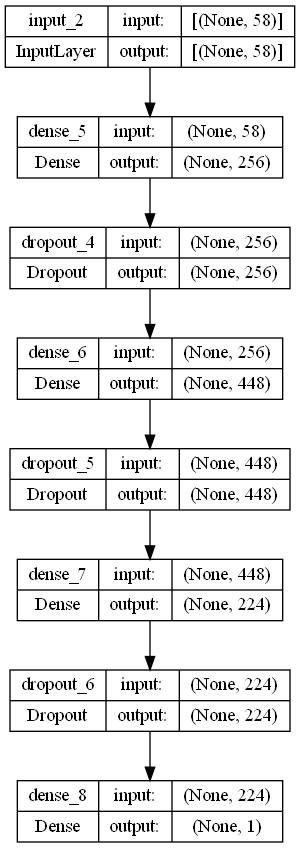

In [1022]:
# vizualize the layers of the NN
plot_model(nn_model_basic_financial_macroecon, to_file='NN_model.png', show_shapes=True, show_layer_names=True)

#### Financial Features (NN)

In [1199]:
# tune and train the model
nn_model_financial = run_nn_tuning(df_financial, y, 'financial')

Trial 200 Complete [00h 00m 44s]
val_loss: 0.7588550448417664

Best val_loss So Far: 0.6888189911842346
Total elapsed time: 01h 12m 17s
INFO:tensorflow:Oracle triggered exit
{'num_hidden_layers': 2, 'hidden_neuron_0': 64, 'hidden_act_0': 'tanh', 'l2_weight_0': 0.0, 'dropout_rate_0': 0.1, 'learning_rate': 0.0001, 'hidden_neuron_1': 288, 'hidden_act_1': 'relu', 'l2_weight_1': 0.0, 'dropout_rate_1': 0.2, 'hidden_neuron_2': 32, 'hidden_act_2': 'leaky_relu', 'l2_weight_2': 0.0001, 'dropout_rate_2': 0.0, 'hidden_neuron_3': 160, 'hidden_act_3': 'relu', 'l2_weight_3': 0.0, 'dropout_rate_3': 0.2, 'hidden_neuron_4': 320, 'hidden_act_4': 'tanh', 'l2_weight_4': 0.0, 'dropout_rate_4': 0.0}


In [1200]:
# compute the performance of the best model 
train_nn(nn_model_financial, df_financial, y)

Epoch 1/100
36/36 [==============================] - 1s 14ms/step - loss: 0.6983 - val_loss: 0.6942
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.6898 - val_loss: 0.6943
Epoch 3/100
36/36 [==============================] - 0s 9ms/step - loss: 0.6859 - val_loss: 0.6947
Epoch 4/100
36/36 [==============================] - 0s 9ms/step - loss: 0.6863 - val_loss: 0.6945
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.6820 - val_loss: 0.6945
Epoch 6/100
23/23 [==============================] - 0s 1ms/step
Epoch 1/100
36/36 [==============================] - 0s 10ms/step - loss: 0.6900 - val_loss: 0.6945
Epoch 2/100
36/36 [==============================] - 0s 9ms/step - loss: 0.6837 - val_loss: 0.6956
Epoch 3/100
36/36 [==============================] - 0s 9ms/step - loss: 0.6832 - val_loss: 0.6963
Epoch 4/100
36/36 [==============================] - 0s 12ms/step - loss: 0.6859 - val_loss: 0.6961
Epoch 5/100
36/36 [=====================

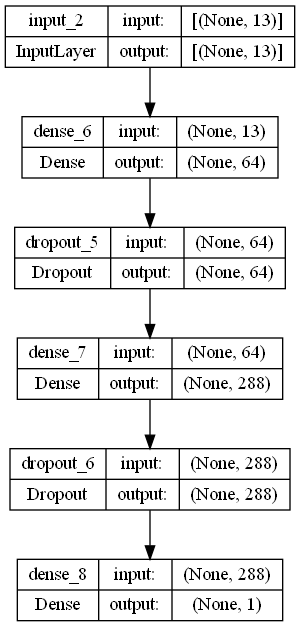

In [1207]:
# vizualize the layers of the NN
plot_model(nn_model_financial, to_file='NN_model.png', show_shapes=True, show_layer_names=True)

#### Macroeconomic Features (NN)

In [1201]:
# tune and train the model
nn_model_macroecon = run_nn_tuning(df_macroecon, y, 'macroecon')

Trial 200 Complete [00h 00m 30s]
val_loss: 0.6981807351112366

Best val_loss So Far: 0.6921044588088989
Total elapsed time: 01h 09m 13s
INFO:tensorflow:Oracle triggered exit
{'num_hidden_layers': 3, 'hidden_neuron_0': 480, 'hidden_act_0': 'relu', 'l2_weight_0': 1e-05, 'dropout_rate_0': 0.0, 'learning_rate': 0.0001, 'hidden_neuron_1': 416, 'hidden_act_1': 'leaky_relu', 'l2_weight_1': 0.0, 'dropout_rate_1': 0.30000000000000004, 'hidden_neuron_2': 64, 'hidden_act_2': 'relu', 'l2_weight_2': 0.0, 'dropout_rate_2': 0.2, 'hidden_neuron_3': 512, 'hidden_act_3': 'tanh', 'l2_weight_3': 0.0001, 'dropout_rate_3': 0.4, 'hidden_neuron_4': 512, 'hidden_act_4': 'tanh', 'l2_weight_4': 0.0001, 'dropout_rate_4': 0.30000000000000004}


In [1202]:
# compute the performance of the best model 
train_nn(nn_model_macroecon, df_macroecon, y)

Epoch 1/100
36/36 [==============================] - 2s 24ms/step - loss: 0.6940 - val_loss: 0.7016
Epoch 2/100
36/36 [==============================] - 1s 20ms/step - loss: 0.6929 - val_loss: 0.7001
Epoch 3/100
36/36 [==============================] - 1s 18ms/step - loss: 0.6884 - val_loss: 0.6985
Epoch 4/100
36/36 [==============================] - 1s 18ms/step - loss: 0.6864 - val_loss: 0.6999
Epoch 5/100
36/36 [==============================] - 1s 22ms/step - loss: 0.6876 - val_loss: 0.6999
Epoch 6/100
36/36 [==============================] - 1s 23ms/step - loss: 0.6861 - val_loss: 0.6985
Epoch 7/100
36/36 [==============================] - 1s 19ms/step - loss: 0.6857 - val_loss: 0.7017
Epoch 8/100
23/23 [==============================] - 0s 5ms/step
Epoch 1/100
36/36 [==============================] - 1s 23ms/step - loss: 0.6868 - val_loss: 0.6981
Epoch 2/100
36/36 [==============================] - 1s 24ms/step - loss: 0.6873 - val_loss: 0.6963
Epoch 3/100
36/36 [================

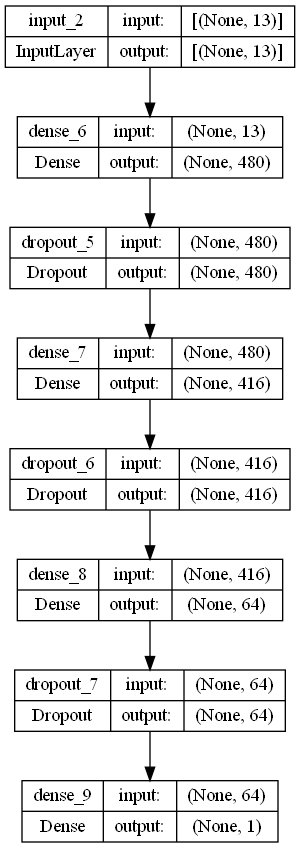

In [1209]:
# vizualize the layers of the NN
plot_model(nn_model_macroecon, to_file='NN_model.png', show_shapes=True, show_layer_names=True)